# Set up

In [ ]:
from pypdf import PdfReader
from IPython.display import Image
import cohere
from io import BytesIO
from PIL import Image as PILImage

def display_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    for i, page in enumerate(reader.pages):
        img = Image(page.to_image())
        display(img)


QUESTION_FORMAT = """
Question [number]
[Question text]
A) [Option A]
B) [Option B]
C) [Option C]
D) [Option D]
"""

EXAMPLE = """
Input: 
======
18. Isabel compró cierta cantidad de bandejas y de huevos. Al colocar n huevos en 
cada bandeja, le sobraban m huevos y si colocaba p huevos en cada bandeja, le 
sobraban q bandejas. Si x representa la cantidad de bandejas de huevos e y la cantidad de huevos 
comprados por Isabel, ¿cuál de los siguientes sistemas de ecuaciones representa 
la situación planteada?  
A) nx + m = y 
p(x - q) = y
B) nx - m = y 
p(x - q) = y 
C) nx + m = y 
p(x + q) = y
D) nx + m = y 
px - q = y 
=====

Output:
=======
Question 18
Isabel compró cierta cantidad de bandejas y de huevos. Al colocar n huevos en cada bandeja, le sobraban m huevos y si colocaba p huevos en cada bandeja, le sobraban q bandejas. Si x representa la cantidad de bandejas de huevos e y la cantidad de huevos comprados por Isabel, ¿cuál de los siguientes sistemas de ecuaciones representa la situación planteada?
A) nx + m = y; p(x - q) = y
B) nx - m = y; p(x - q) = y
C) nx + m = y; p(x + q) = y
D) nx + m = y; px - q = y
"""

def extract_questions(text: str, co: cohere.Client, language: str) -> str:
    prompt = f"""Please extract the multiple-choice questions from the following text.

The questions are in {language} and follow this format:

{QUESTION_FORMAT}

Please maintain this exact format in your response, including the prefix and the lettered options. 

Here's the text:

{text}"""

    response = co.chat(
        model="command-r-plus",
        message=prompt
    )
    return response.text

def parse_cohere_output(output: str):
    questions = []
    current_question = None
    for line in output.split('\n'):
        line = line.strip()
        if not line:
            continue
        if line.lower().startswith('pyetja') or line.lower().startswith('question'):
            if current_question:
                questions.append(current_question)
            current_question = {'question_number': line, 'question_text': '', 'choices': []}
        elif current_question and not current_question['question_text']:
            current_question['question_text'] = line
        elif line.startswith(('A)', 'B)', 'C)', 'D)')):
            if current_question is None:
                current_question = {'question_number': 'Unknown', 'question_text': 'Unknown', 'choices': []}
            current_question['choices'].append(line)
    
    if current_question:
        questions.append(current_question)
    
    return questions

In [ ]:
!pip install -r requirements.txt

In [14]:
!wget "https://m.shsbnu.net/pluginfile.php/38738/mod_resource/content/1/%5B2018-Official-AP%20Practice%20Exam%5D%20(With%20Answers).pdf"

156.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--2024-12-18 12:01:34--  https://m.shsbnu.net/pluginfile.php/38738/mod_resource/content/1/%5B2018-Official-AP%20Practice%20Exam%5D%20(With%20Answers).pdf
Resolving m.shsbnu.net (m.shsbnu.net)... 106.120.108.165
Connecting to m.shsbnu.net (m.shsbnu.net)|106.120.108.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5506671 (5.3M) [application/pdf]
Saving to: ‘[2018-Official-AP Practice Exam] (With Answers).pdf’

[2018-Official-AP P 100%[===================>]   5.25M  1.23MB/s    in 4.8s    

2024-12-18 12:01:40 (1.10 MB/s) - ‘[2018-Official-AP Practice Exam] (With Answers).pdf’ saved [5506671/5506671]



# Configuration

In [14]:
INPUT_FILE_PATH = 'JEEAdv2024_Paper2_Hindi.pdf'
SOURCE = "https://m.shsbnu.net/pluginfile.php/38738/mod_resource/content/1/%5B2018-Official-AP%20Practice%20Exam%5D%20(With%20Answers).pdf"
LANGUAGE = "en"
COUNTRY = ""
LICENSE = ""
LEVEL = ""
CATEGORY_EN = ""
CATEGORY_ORIGINAL_LANG = ""
cohere_api_key = "oEC6kZWYlCTv9sQBPdJEPViXx5WSFezyC5M3Bm7o"
co = cohere.Client(api_key=cohere_api_key)
question_denomination = "Pyetja" if LANGUAGE == "al" else "Question" # Change this to the appropriate questions denomination in the language of the text
pages = (9, 11) # Set this to the pages you want to extract questions from, e.g. (1, 3) to extract questions from the second to fourth pages

# Read PDF

Page 9 has 1 images


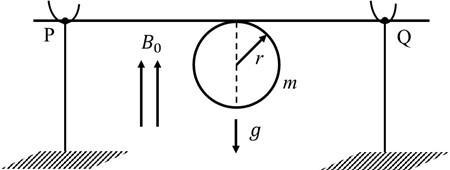

In [16]:
reader = PdfReader(INPUT_FILE_PATH)
text = []
output = {}
for page in reader.pages[pages[0]:pages[1]] if pages else reader.pages:
    text.append(page.extract_text(extraction_mode="plain").strip())
    if len(page.images) > 0:
        print(f"Page {page.page_number} has {len(page.images)} images")
        for image in page.images:
            # Display the image
            display(image.image)
            if input("Does this image relate to a question? (y/n) ").lower() == "y":
                # Get the question number
                answer = input("Enter the question number and 'r' if it is related (example: '1r', otherwise it is an answer option): ")
                question_number = int(answer[0])
                if question_number not in output.keys():
                    output[question_number] = {"langauge": LANGUAGE, "country": COUNTRY, "license": LICENSE, "file_name": INPUT_FILE_PATH, "level": LEVEL, "category_en": CATEGORY_EN, "question": "", "options": [], "original_question_num": question_number, "category_original_lang": CATEGORY_ORIGINAL_LANG, "image_png": "", "image_type": "", "image_information": "", "parallel_questions_id": None}
                # Save image in question folder
                answer_option = len(output[question_number]["options"])
                x =  f"{INPUT_FILE_PATH[:-4]}/question_{question_number}_{answer_option}.png" 
                if answer[-1] == "r":
                    image_type = input("Enter the image type (table, ...): ")
                    if input("Is this image needed? (y/n) ").lower() == "y":
                        output[question_number]["image_information"] = "essential"
                    answer_option = "r"
                    output[question_number]["image_type"] = image_type
                    output[question_number]["image_png"] = x
                else:
                    output[question_number]["options"].append(x)
                image.image.save(x)
all_text = " ".join(text)
if question_denomination in all_text:
    for number, question in enumerate(all_text.split(question_denomination)):
        question_text = all_text.split(question_denomination)[number-1][:100] + question
        if output.get(number) is None:
            output[number] = {"langauge": LANGUAGE, "country": COUNTRY, "license": LICENSE, "file_name": INPUT_FILE_PATH, "level": LEVEL, "category_en": CATEGORY_EN, "question": question_text, "options": [], "original_question_num": number, "category_original_lang": CATEGORY_ORIGINAL_LANG, "image_png": "", "image_type": "", "image_information": "", "parallel_questions_id": None}
        response = parse_cohere_output(extract_questions(question_text, co, LANGUAGE))
        if len(response) > 1:
            print(f"Denomination for question {question_denomination} leads to multiple question in the splits")
        for question in response:
            if question["question_number"] == "Unknown":
                for i in range(1000):
                    if f"{i}unkown" not in output.keys():
                        number = f"{i}unkown"
                        output[i] = {"langauge": LANGUAGE, "country": COUNTRY, "license": LICENSE, "file_name": INPUT_FILE_PATH, "level": LEVEL, "category_en": CATEGORY_EN, "question": question["question_text"], "options": question["choices"], "original_question_num": i, "category_original_lang": CATEGORY_ORIGINAL_LANG, "image_png": "", "image_type": "", "image_information": "", "parallel_questions_id": None}
                        break
            else:
                number = int(question["question_number"].split(" ")[1])
            output[number]["question"] = question["question_text"]
            output[number]["options"] = question["choices"]
else:
    # Process page by page
    for number, page in enumerate(text):
        response = parse_cohere_output(extract_questions(page, co, LANGUAGE))
        for question in response:
            if question["question_number"] == "Unknown":
                for i in range(1000):
                    if f"{i}unkown" not in output.keys():
                        number = f"{i}unkown"
                        output[i] = {"langauge": LANGUAGE, "country": COUNTRY, "license": LICENSE, "file_name": INPUT_FILE_PATH, "level": LEVEL, "category_en": CATEGORY_EN, "question": question["question_text"], "options": question["choices"], "original_question_num": i, "category_original_lang": CATEGORY_ORIGINAL_LANG, "image_png": "", "image_type": "", "image_information": "", "parallel_questions_id": None}
                        break
            else:
                number = int(question["question_number"].split(" ")[1])
            if number not in output.keys():
                output[number] = {"langauge": LANGUAGE, "country": COUNTRY, "license": LICENSE, "file_name": INPUT_FILE_PATH, "level": LEVEL, "category_en": CATEGORY_EN, "question": question["question_text"], "options": question["choices"], "original_question_num": number, "category_original_lang": CATEGORY_ORIGINAL_LANG, "image_png": "", "image_type": "", "image_information": "", "parallel_questions_id": None}
            else:
                output[number]["question"] = question["question_text"]
                output[number]["options"] = question["choices"]

# Output results correctly

In [19]:
import json
result = list(output.values())
json.dump(result, open(f"{INPUT_FILE_PATH[:-4]}_questions.json", "w"))

In [9]:
import os
os.makedirs("JEEAdv2024_Paper2_Hindi)")